In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay
import numpy as np
import pandas as pd

In [2]:
#read in terrorism dataset
terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")

#only include those terrorist attacks that met the three criteria listed in the codebook
mask = (terrorism['crit1'] == 1) & (terrorism['crit3'] == 1) & (terrorism['crit3'] == 1)
terrorism = terrorism[mask].drop(columns = ['crit1', 'crit2', 'crit3'])
terrorism.head()

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\4056924959.py:2: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terrorism = pd.read_csv(r"C:\Users\ryanc\Downloads\gtd_full.csv")


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Training the SVM pipeline with linear kernel...

--- SVM Results ---
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83     30392
           1       0.82      0.70      0.76     24514

    accuracy                           0.80     54906
   macro avg       0.80      0.79      0.79     54906
weighted avg       0.80      0.80      0.80     54906



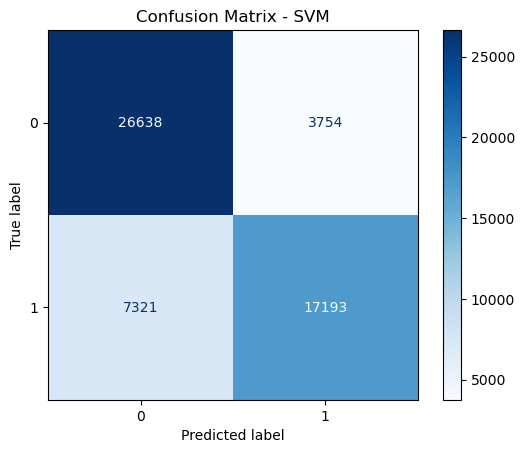

In [3]:
# Create the target variable
terrorism['civilian_deaths'] = terrorism['nkill'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

# Define numerical and categorical columns
numerical_columns = ['nkillter', 'nwound', 'iyear', 'suicide', 'extended', 'success']
categorical_columns = ['attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'region_txt']

# Split the dataset into features (X) and target (y)
X = terrorism[numerical_columns + categorical_columns]
y = terrorism['civilian_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Sample 50,000 rows from the training set
X_train_sample = X_train.sample(n=50000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Preprocessing pipeline with parallelism
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), categorical_columns),
    ],
    n_jobs=-1  # Enable parallel processing
)

# Full pipeline with preprocessing and SVM
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='linear', probability=True, random_state=42, cache_size=700))
])

# Train the SVM model with the sampled training set
print("Training the SVM pipeline with linear kernel...")
pipeline.fit(X_train_sample, y_train_sample)

# Evaluate the model
print("\n--- SVM Results ---")
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[0, 1]).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - SVM")
plt.show()

# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]


--- Logistic Regression for Threshold Optimization ---
Optimal Threshold: 0.50

Performance at Logistic Regression-Optimized Threshold:
Precision: 0.8199
Recall: 0.7079
F1 Score: 0.7598


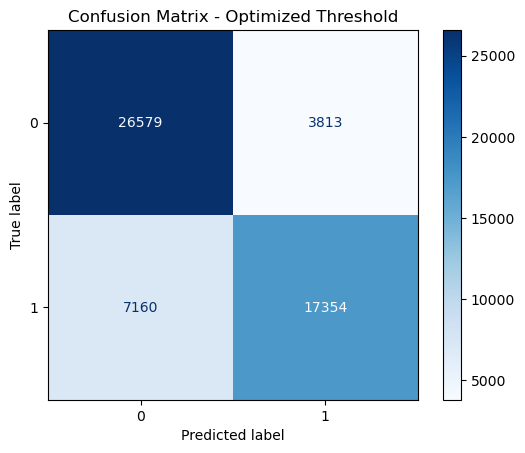

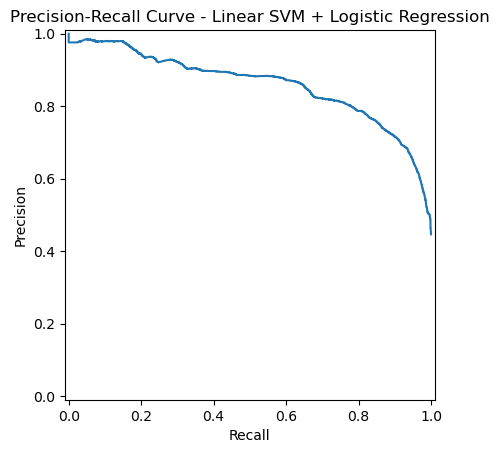

In [4]:

# Logistic Regression for Threshold Optimization
print("\n--- Logistic Regression for Threshold Optimization ---")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(y_pred_proba.reshape(-1, 1), y_test)

# Define thresholds in the range [0.5, 0.99]
thresholds = np.linspace(0.5, 0.99, 50)

# Evaluate precision, recall, and F1 scores for thresholds
precision_scores, recall_scores, f1_scores = [], [], []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Find the optimal threshold based on F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Evaluate at the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)

print("\nPerformance at Logistic Regression-Optimized Threshold:")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")

# Confusion Matrix at Optimal Threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=[0, 1]).plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Optimized Threshold")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve - Linear SVM + Logistic Regression")
plt.show()